<a href="https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/LLM_Inference_with_AutoGPTQ_WizardCoder_15B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGPTQ

AutoGPTQ is a user-friendly quantization package for Large Language Models (LLMs) based on the GPTQ algorithm. The purpose of this package is to allow users to easily quantize and optimize their language models for inference, making them faster and more efficient while preserving acceptable model quality.

| Code Credits | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/PanQiWei/AutoGPTQ?style=social)](https://github.com/PanQiWei/AutoGPTQ) |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/InsightSolver-Colab/) |


In [ ]:
pip install auto-gptq==0.2.2

# Select the model


First, we need to specify the model to use. In Colab with T4 GPU, we can run models of up to 20B of parameters with all optimizations, but this may degrade the quality of the model's inference.

In this case, we will use a [WizardCoder](https://huggingface.co/WizardLM/WizardCoder-15B-V1.0), which is a model optimized for generating code in different programming languages.


![asd](https://raw.githubusercontent.com/nlpxucan/WizardLM/main/WizardCoder/imgs/pass1.png)






# Model quantization

The model needs more VRAM than we have available, so we have to quantize it. One alternative for this procedure is to use [GPTQ-for-LLaMa](https://github.com/qwopqwop200/GPTQ-for-LLaMa) or use the method provided by auto_gptq:


In [ ]:
### Demo quantization for facebook/opt-125m to 4bits ###
from transformers import AutoTokenizer, TextGenerationPipeline
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

pretrained_model_dir = "facebook/opt-125m"
quantized_model_dir = "opt-125m-4bit"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_dir, use_fast=True)

examples = [
    tokenizer(
        "auto-gptq is an easy-to-use model quantization library with user-friendly apis, based on GPTQ algorithm."
    )
]

quantize_config = BaseQuantizeConfig(
    bits=4,  # quantize model to 4-bit
    group_size=128,  # it is recommended to set the value to 128
    desc_act=False,  # set to False can significantly speed up inference but the perplexity may slightly bad
)

# load un-quantized model, by default, the model will always be loaded into CPU memory
model = AutoGPTQForCausalLM.from_pretrained(pretrained_model_dir, quantize_config)

# quantize model, the examples should be list of dict whose keys can only be "input_ids" and "attention_mask"
model.quantize(examples)

# save quantized model
model.save_quantized(quantized_model_dir)

# save quantized model using safetensors
model.save_quantized(quantized_model_dir, use_safetensors=True)

However, we still need more VRAM to quantize the wizardcoder with auto_gptq.

#  Quantized Models from the Hugging Face Community

Fortunately, the Hugging Face community provides quantized models in `safetensor format`. This allows us to use the model on the T4 GPU efficiently, effectively and more safely.

There are various variations, but the ones that interest us are those based on the GPTQ algorithm.

We can see the different variations that WizardCoder has [here](https://huggingface.co/models?search=wizardcoder).



In this case, we will use the model called [WizardCoder-Guanaco-15B-V1.1-GPTQ](https://huggingface.co/TheBloke/WizardCoder-Guanaco-15B-V1.1-GPTQ), which is a finetuned model using the dataset from [openassistant-guanaco](https://huggingface.co/datasets/timdettmers/openassistant-guanaco).

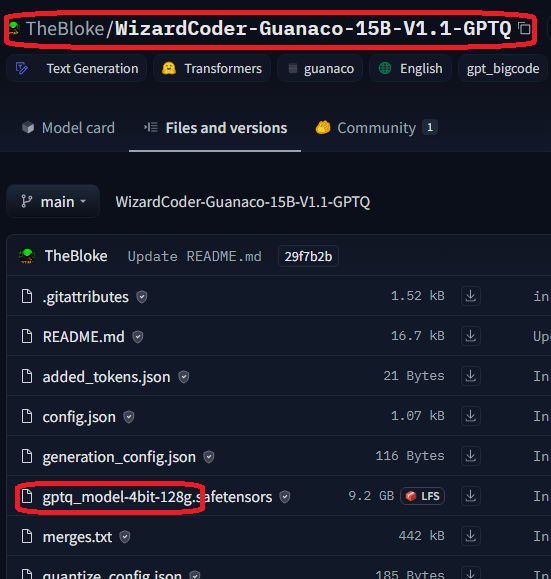

In [ ]:
model_name_or_path = "TheBloke/WizardCoder-Guanaco-15B-V1.1-GPTQ"
model_basename = "gptq_model-4bit-128g"

First, we load the model.

In [ ]:
from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

# AutoGPTQ supports using triton to speedup inference, but it currently only supports Linux | pip install auto-gptq[triton]
use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        model_basename=model_basename,
        #revision="gptq-4bit-32g-actorder_True", # from a specific branch, use the revision parameter, else commet this line
        use_safetensors=True,
        trust_remote_code=False,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None
        )

We can obtain information about the model's configuration with

In [ ]:
model.config

GPTBigCodeConfig {
  "_name_or_path": "TheBloke/WizardCoder-Guanaco-15B-V1.1-GPTQ",
  "activation_function": "gelu",
  "architectures": [
    "GPTBigCodeForCausalLM"
  ],
  "attention_softmax_in_fp32": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "inference_runner": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "max_batch_size": null,
  "max_sequence_length": null,
  "model_type": "gpt_bigcode",
  "multi_query": true,
  "n_embd": 6144,
  "n_head": 48,
  "n_inner": 24576,
  "n_layer": 40,
  "n_positions": 8192,
  "pad_key_length": true,
  "pre_allocate_kv_cache": false,
  "resid_pdrop": 0.1,
  "scale_attention_softmax_in_fp32": true,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float16",
  "transformers_version": "4.30.2",
  "use_cache": true,
  "validate_runner_inpu

And the quantization configuration that was used.

In [ ]:
model.quantize_config

BaseQuantizeConfig(bits=4, group_size=128, damp_percent=0.01, desc_act=False, sym=True, true_sequential=True, model_name_or_path='TheBloke/WizardCoder-Guanaco-15B-V1.1-GPTQ', model_file_base_name='gptq_model-4bit-128g')

# Inference

We will use this prompt.

In [ ]:
prompt = "Write a linear regresion in python"
prompt_template=f'''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: {prompt}

### Response:
'''

## Inference with transformers pipeline

In [ ]:
logging.set_verbosity(logging.CRITICAL)

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

print(pipe(prompt_template)[0]['generated_text'])


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a linear regresion in python

### Response:
A Linear Regression model in Python can be implemented using scikit-learn library's `LinearRegression` class, which provides methods for fitting a regression line to data and predicting target values. Here are some steps you would follow when implementing this:

1. Import necessary libraries like numpy and sklearn.linear_model
    ```python
    import numpy as np 
    from sklearn.linear_model import LinearRegression
    ```
    
2. Generate random input data (X) with 100 samples and one independent variable (x). The relationship between X and y will be defined later on during training process.

    ```python
    x = np.random.rand(100,)  
    noise = np.random.normal(loc=0, scale=5, size=(100,)) # add normal noise
    y = 3*x + 4 + noise   # create a noisy sine wave signal
    print("Shape of our dataset:", x.shap

## Inference with model.generate

In [ ]:
input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()

output = model.generate(
    inputs=input_ids,
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
    )

print(tokenizer.decode(output[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a linear regresion in python

### Response:
A Linear Regression model in Python can be implemented using scikit-learn library's `LinearRegression` class, which provides methods for fitting a regression line to data and predicting target values. Here are some steps you would follow when implementing this:

1. Import necessary libraries like numpy and sklearn.linear_model
    ```python
    import numpy as np 
    from sklearn.linear_model import LinearRegression
    ```
    
2. Generate random input data (X) with 100 samples and one independent variable (x). The relationship between X and y will be defined later on during training process.

    ```python
    x = np.random.rand(100,)  
    noise = np.random.normal(loc=0, scale=5, size=(100,)) # add normal noise
    y = 3*x + 4 + noise   # create a noisy sine wave signal
    print("Shape of our dataset:", x.shap

# Real-time output (stream tokens)

Real-time output allows continuous display of generated text as it is processed.

## Basic token streaming



You can appreciate an example of how it is implemented in Gradio [here](https://huggingface.co/spaces/joaogante/transformers_streaming).

In [ ]:
import sys
import time

def real_time_print(string):
    for char in string:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(0.1)  # adjust the sleep time to control the printing speed

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TextIteratorStreamer
from threading import Thread

model_inputs = tokenizer([prompt_template], return_tensors="pt").to('cuda')

# Adds timeout to the streamer to handle exceptions in the generation thread.
streamer = TextIteratorStreamer(tokenizer, timeout=10., skip_prompt=True, skip_special_tokens=True)
generate_kwargs = dict(
    model_inputs,
    streamer=streamer,
    max_new_tokens=2000,
    do_sample=True,
    top_p=0.9,
    temperature=float(0.7),
    top_k=40
)
t = Thread(target=model.generate, kwargs=generate_kwargs)
t.start()

# Pull the generated text from the streamer, and update the model output.
model_output = ""
for new_text in streamer:
    model_output += new_text
    real_time_print(new_text)


A linear regression in Python is a type of statistical analysis that uses a linear model to relate dependent variables to independent variables. Here's a simple example of how to do it using the statsmodels library:

```python
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS

# Create a dataset
data = {'X1': [1, 2, 3, 4, 5], 'X2': [2, 3, 4, 5, 6], 'Y': [1, 2, 3, 4, 5]}
df = pd.DataFrame(data)

# Create a linear regression model
X = df[['X1', 'X2']]
y = df['Y']
model = OLS(y, X)

# Fit the model
results = model.fit()

# Print the coefficients
print(results.params)
```

In this code, the `OLS` class is used to create a linear regression model. The `fit` method is then used to fit the model, which returns a results object with various statistical measures. The coefficients of the model are accessed through the `params` attribute.

Please note that the `statsmodels` library in Python needs to be installed. If it's not installed, you can install it

## Batch token streaming
"This method can improve the inference time."

In [ ]:
import torch
from IPython.display import Markdown, display

def hr(): display(Markdown('---'))
def cprint(msg: str, color: str = "blue", **kwargs) -> None:
    color_codes = {
        "blue": "\033[34m",
        "red": "\033[31m",
        "green": "\033[32m",
        "yellow": "\033[33m",
        "purple": "\033[35m",
        "cyan": "\033[36m",
    }

    if color not in color_codes:
        raise ValueError(f"Invalid info color: `{color}`")

    print(color_codes[color] + msg + "\033[0m", **kwargs)

cprint('Function to give color to texts', color="green")

Function to give color to texts


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria, StoppingCriteriaList
from threading import Thread
from IPython.display import clear_output

model_inputs = tokenizer([prompt_template], return_tensors="pt").to('cuda')

# in the main thread. Adds timeout to the streamer to handle exceptions in the generation thread.
streamer = TextIteratorStreamer(tokenizer, timeout=10., skip_prompt=True, skip_special_tokens=True)
generate_kwargs = dict(
    model_inputs,
    streamer=streamer,
    max_new_tokens=2000,
    do_sample=True,
    top_p=0.9,
    temperature=float(0.7),
    top_k=40
)
t = Thread(target=model.generate, kwargs=generate_kwargs)
t.start()

# Pull the generated text from the streamer, and update the model output.
model_output = ""
count= 0
token_batch = 50

for new_text in streamer:
    model_output += new_text
    count += 1
    if count == token_batch:
      count = 0

      clear_output(wait=False)
      cprint(prompt_template)
      hr()
      cprint(model_output, color="green")

clear_output(wait=False)
cprint(prompt_template)
hr()
cprint(model_output, color="green")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a linear regresion in python

### Response:



---


Here is an example of a simple linear regression in Python using the scikit-learn library. This code performs a simple linear regression on a dataset to predict the price of a house.

```python
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('house_data.csv')

# Split the data into training and testing sets
X = data['Size']
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Make predictions on the test data
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Calculate the mean squared error (MSE)
mse = np.mean((y_pred - y_test)**2)

# Print the coefficient and intercept of the model
print(f'Coefficient: {model.coef_[0][